![metodology](https://www.muycomputerpro.com/wp-content/uploads/2019/03/machine_learning_train.jpeg)

## Cargar el Dataset

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("./Dataset/charlie_e44.csv")
df.info()
df.Groom.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9075 entries, 0 to 9074
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   User    9075 non-null   object
 1   Text    9075 non-null   object
 2   Groom   9075 non-null   bool  
dtypes: bool(1), object(2)
memory usage: 150.8+ KB


True     5008
False    4067
Name: Groom, dtype: int64

In [3]:
df

,User,Text,Groom
0,charlie_e44,hi,True
1,charlie_e44,oipps sorry wrong person,True
2,bethaneyizbored,okie dokie,False
3,charlie_e44,lol cool,True
4,charlie_e44,just bord rite,True
...,...,...,...
9070,bethaneyizbored,tahts not far from me cuz we live on a circle ...,False
9071,bethaneyizbored,i see u 2morow,False
9072,charlie_e44,suped motel i cannot sighn in till 200 and i a...,True
9073,charlie_e44,if you are not at kfc i am coming back home se...,True


## Extracción y selección de características del texto
Convertir texto en una matriz de tokens contables 

In [4]:
#from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
#from nltk.corpus import stopwords
#from sklearn.feature_selection import SelectKBest, chi2

In [5]:
#CV = CountVectorizer()
#TF_IDF = TfidfVectorizer(ngram_range=(1,2))
#KChi = SelectKBest(chi2, k=10e3)

## Dividir el conjunto de datos en entrenamiento y prueba
Retenemos algún subconjunto de los datos del entrenamiento del modelo y luego usamos este conjunto de reserva para verificar el rendimiento del modelo

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Groom'], test_size=0.2, random_state=4)

## Determinar parámetros para el clasificador ##

In [8]:
#from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline

## Pasar los datos al clasificador ##

In [9]:
from sklearn.naive_bayes import ComplementNB # Clasificador de Naive Bayes
from sklearn.svm import SVC # Clasificador de Suport Vector Machine
from sklearn.ensemble import RandomForestClassifier # Clasificador de Bosques Aleatorios

In [56]:
modelMNB = make_pipeline(TfidfVectorizer(ngram_range=(1,2)), ComplementNB())
modelSVM = make_pipeline(TfidfVectorizer(ngram_range=(1,2)), SVC(probability=True))
modelRFC = make_pipeline(TfidfVectorizer(ngram_range=(1,2)), RandomForestClassifier())

In [11]:
#Y_train = y_train.astype('int')
#Y_test = y_test.astype('int')
#TF_IDF.fit_transform(X_train)

In [12]:
%timeit modelMNB.fit(X_train, y_train)

166 ms ± 15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [58]:
%timeit modelSVM.fit(X_train, y_train)

17.1 s ± 593 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%timeit modelRFC.fit(X_train, y_train)

6.89 s ± 453 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
Y_predMNB = modelMNB.predict(X_test)

In [59]:
Y_predSVM = modelSVM.predict(X_test)

In [17]:
Y_predRFC = modelRFC.predict(X_test)

## Evaluar el modelo

### Matriz de confisuión
Las filas de la matriz indican la clase real y las columnas las clases predichas.
La matriz de confusión en si misma no es una medida de rendimiento, pero casi todas la métricas se basan en ellas.
1. **Verdaderos positivos:** Son los casos donde los datos reales son 1 y la predicción es 1
2. **Verdaderos negativos:** Son los casos donde los datos reales son 0 y la predicción es 0
3. **Falsos positivos:** Son los casos donde los datos reales son 0 y la predicción es 1
4. **Falsos negativos:** Son los casos donde los datos reales son 1 y la predicción es 0

### Métricas de evaluación

1. **Exacitud:** Es el número de predicciones correctas realizadas por el modelo por el número total de registros
2. **Precisión:** Evalua los datos por su desempeño de predicciones positivas
3. **Sensibilidad o Recall:** Se calcula como el número de predicciones positivas correctas dividido por el número total de positivos
4. **Especificidad:** Se calcula como el número de predicciones negativas correctas dividido por el número total de negativos
5. **Puntaje F1:** Es el promedio ponderado de precisión y sensibilidad

### Curva ROC y Área Bajo la Curva (AUC)

1. **Características del funcionamiento del receptor (ROC):** Nos dice que tan bien puede distinguir el modelo entre dos clases
2. **Área bajo la curva (AUC):** Nos dice que tan bien funciona el modelo

In [18]:
from sklearn.metrics import *

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

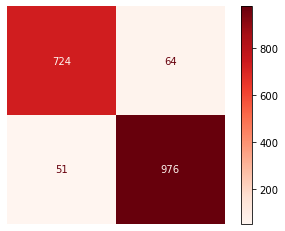

In [20]:
confusion_matrix(y_test, Y_predMNB)
plot_confusion_matrix(modelMNB, X_test, y_test, cmap=plt.cm.Reds)
plt.axis('off')
plt.show()

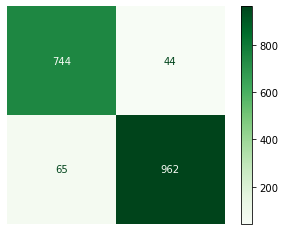

In [21]:
confusion_matrix(y_test, Y_predSVM)
plot_confusion_matrix(modelSVM, X_test, y_test, cmap=plt.cm.Greens)
plt.axis('off')
plt.show()

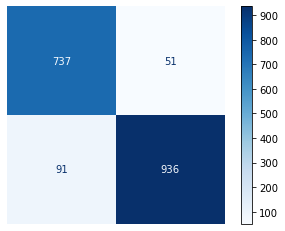

In [23]:
confusion_matrix(y_test, Y_predRFC)
plot_confusion_matrix(modelRFC, X_test, y_test, cmap=plt.cm.Blues)
plt.axis('off')
plt.show()

In [24]:
print(classification_report(y_test, Y_predMNB)) # Reporte Clasificador Naive Bayes

              precision    recall  f1-score   support

       False       0.93      0.92      0.93       788
        True       0.94      0.95      0.94      1027

    accuracy                           0.94      1815
   macro avg       0.94      0.93      0.94      1815
weighted avg       0.94      0.94      0.94      1815



In [25]:
print(classification_report(y_test, Y_predSVM)) # Reporte Clasificador SVM

              precision    recall  f1-score   support

       False       0.92      0.94      0.93       788
        True       0.96      0.94      0.95      1027

    accuracy                           0.94      1815
   macro avg       0.94      0.94      0.94      1815
weighted avg       0.94      0.94      0.94      1815



In [26]:
print(classification_report(y_test, Y_predRFC)) # Reporte Clasificador Random Forest

              precision    recall  f1-score   support

       False       0.89      0.94      0.91       788
        True       0.95      0.91      0.93      1027

    accuracy                           0.92      1815
   macro avg       0.92      0.92      0.92      1815
weighted avg       0.92      0.92      0.92      1815



In [27]:
print(f"Error absoluto medio [NB]: {(mean_absolute_error(y_test.astype('int'), Y_predMNB.astype('int'))*100).round(2)}%")
print(f"Puntaje R^2 [NB]: {(r2_score(y_test.astype('int'), Y_predMNB.astype('int'))*100).round(2)}%")

Error absoluto medio [NB]: 6.34%
Puntaje R^2 [NB]: 74.21%


In [28]:
print(f"Error absoluto medio [SVM]: {(mean_absolute_error(y_test.astype('int'), Y_predSVM.astype('int'))*100).round(2)}%")
print(f"Puntaje R^2 [SVM]: {(r2_score(y_test.astype('int'), Y_predSVM.astype('int'))*100).round(2)}%")

Error absoluto medio [SVM]: 6.01%
Puntaje R^2 [SVM]: 75.55%


In [29]:
print(f"Error absoluto medio [RFC]: {(mean_absolute_error(y_test.astype('int'), Y_predRFC.astype('int'))*100).round(2)}%")
print(f"Puntaje R^2 [RFC]: {(r2_score(y_test.astype('int'), Y_predRFC.astype('int'))*100).round(2)}%")

Error absoluto medio [RFC]: 7.82%
Puntaje R^2 [RFC]: 68.15%


In [30]:
print("Conjunto de datos:", df.shape, df['Groom'].shape)
print("Conjunto de entrenamiento:", X_train.shape, y_train.shape)
print("Conjunto de prueba:", X_test.shape, y_test.shape)

Conjunto de datos: (9075, 3) (9075,)
Conjunto de entrenamiento: (7260,) (7260,)
Conjunto de prueba: (1815,) (1815,)


In [31]:
print("Métricas de evaluación del modelo Naive Bayes:\n")
print(f"Exactitud: {(accuracy_score(y_test, Y_predMNB)*100).round(2)}%")
print(f"Precisión: {(precision_score(y_test, Y_predMNB)*100).round(2)}%")
print(f"Recuerdo: {(recall_score(y_test, Y_predMNB)*100).round(2)}%")
print(f"Puntuación F1: {(f1_score(y_test, Y_predMNB)*100).round(2)}%")
print(f"Sensibilidad: {(recall_score(y_test, Y_predMNB)*100).round(2)}%")

Métricas de evaluación del modelo Naive Bayes:

Exactitud: 93.66%
Precisión: 93.85%
Recuerdo: 95.03%
Puntuación F1: 94.44%
Sensibilidad: 95.03%


In [32]:
print("Métricas de evaluación del modelo Suport Vector Machine:\n")
print(f"Exactitud: {(accuracy_score(y_test, Y_predSVM)*100).round(2)}%")
print(f"Precisión: {(precision_score(y_test, Y_predSVM)*100).round(2)}%")
print(f"Recuerdo: {(recall_score(y_test, Y_predSVM)*100).round(2)}%")
print(f"Puntuación F1: {(f1_score(y_test, Y_predSVM)*100).round(2)}%")
print(f"Sensibilidad: {(recall_score(y_test, Y_predSVM)*100).round(2)}%")

Métricas de evaluación del modelo Suport Vector Machine:

Exactitud: 93.99%
Precisión: 95.63%
Recuerdo: 93.67%
Puntuación F1: 94.64%
Sensibilidad: 93.67%


In [33]:
print("Métricas de evaluación del modelo Random Forest:\n")
print(f"Exactitud: {(accuracy_score(y_test, Y_predRFC)*100).round(2)}%")
print(f"Precisión: {(precision_score(y_test, Y_predRFC)*100).round(2)}%")
print(f"Recuerdo: {(recall_score(y_test, Y_predRFC)*100).round(2)}%")
print(f"Puntuación F1: {(f1_score(y_test, Y_predRFC)*100).round(2)}%")
print(f"Sensibilidad: {(recall_score(y_test, Y_predRFC)*100).round(2)}%")

Métricas de evaluación del modelo Random Forest:

Exactitud: 92.18%
Precisión: 94.83%
Recuerdo: 91.14%
Puntuación F1: 92.95%
Sensibilidad: 91.14%


In [34]:
y_pred_probMNB = modelMNB.predict_proba(X_test)[:,1]
print(y_pred_probMNB)

[0.02190652 0.26894454 0.95462949 ... 0.9702036  0.61548257 0.89253784]


In [60]:
y_pred_probSVM = modelSVM.predict_proba(X_test)[:,1]
print(y_pred_probSVM)

[0.01425697 0.05398869 0.98766695 ... 0.99687506 0.93111501 0.98606711]


In [37]:
y_pred_probRFC = modelRFC.predict_proba(X_test)[:,1]
print(y_pred_probRFC)

[0.         0.29982693 0.975      ... 0.97       0.77068108 0.88294444]


Puntaje AUC [NB]: 93.46%


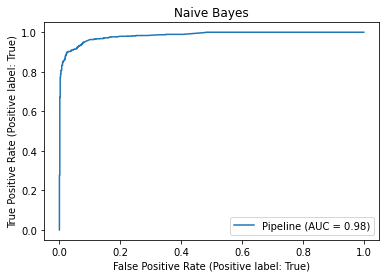

In [38]:
print(f"Puntaje AUC [NB]: {((roc_auc_score(y_test, Y_predMNB))*100).round(2)}%")
plot_roc_curve(modelMNB, X_test, y_test)
plt.title('Naive Bayes')
plt.show()

Puntaje AUC [SVM]: 94.04%


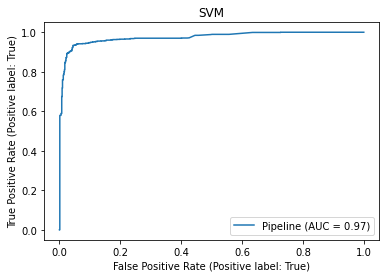

In [39]:
print(f"Puntaje AUC [SVM]: {((roc_auc_score(y_test, Y_predSVM))*100).round(2)}%")
plot_roc_curve(modelSVM, X_test, y_test)
plt.title('SVM')
plt.show()

Puntaje AUC [RF]: 92.33%


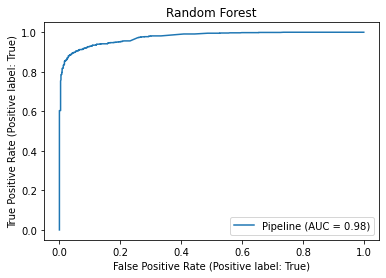

In [40]:
print(f"Puntaje AUC [RF]: {((roc_auc_score(y_test, Y_predRFC))*100).round(2)}%")
plot_roc_curve(modelRFC, X_test, y_test)
plt.title('Random Forest')
plt.show()

## Probar los modelos

In [66]:
#modelMNB.predict_proba(['I go to play soccer'])

In [63]:
modelSVM.predict_proba(['I go to play soccer'])

array([[0.02360516, 0.97639484]])

In [65]:
#modelRFC.predict_proba(['I go to play soccer'])

In [46]:
#from win10toast import ToastNotifier
#toast = ToastNotifier()

In [47]:
def groom_classifier(*msg, model):
    msg_pred = model.predict(msg)
    if msg_pred*100 > 80:
        #toast.show_toast("Alert", "Grooming content in chat!", duration=5)
        print("Grooming content in chat!")
    else:
        print("None")

In [51]:
groom_classifier("Send me a pic of your homework please", model=modelMNB)

Grooming content in chat!


In [52]:
groom_classifier("Send me a pic of your homework please", model=modelSVM)

Grooming content in chat!


In [53]:
groom_classifier("Send me a pic of your homework please", model=modelRFC)

Grooming content in chat!


In [61]:
#!jupyter nbconvert --to webpdf --allow-chromium-download TestClassifiers.ipynb